# Notes on an ARMA(1, 1) Model with NumPyro

This are some notes on how to implement an ARMA(1, 1) model using [`NumPyro`](https://github.com/pyro-ppl/numpyro) for time series forecasting. The ARMA(1, 1) model is given by

$$y_t = \mu + \phi y_{t-1} + \theta \varepsilon_{t-1} + \varepsilon_t$$

where $y_t$ is the time series, $\mu$ is the mean, $\phi$ is the autoregressive parameter, $\theta$ is the moving average parameter, and $\varepsilon_t$ is a white noise process with mean zero and variance $\sigma^2$.

We work ot an end-to-end example: from data generation to model fitting and forecasting. We consolidate this example following the [Example: AR(2) process](https://num.pyro.ai/en/stable/examples/ar2.html) from the documentation and the discussion in the forum thread [Lax.scan to implement ARMA(1, 1)](https://forum.pyro.ai/t/lax-scan-to-implement-arma-1-1/3203). In addition, we use some code from some previous notes [exponential smoothing](https://juanitorduz.github.io/exponential_smoothing_numpyro/).

## Prepare Notebook

In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import lax, random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Data

Whenever getting started with time series models (specially the ones with autoregressive and moving average components), it is a good idea to generate some data to understand how the model works. In addition, we can verify our models by trying to recover the parameters. We generate a time series with $100$ observations using the ARMA(1, 1) model. We set the parameters $\mu = 0.0$, $\phi = 0.4$, $\theta = 0.7$, and $\sigma = 0.5$.

In [2]:
n_samples = 100 + 1

mu = 0.0
phi = 0.4
theta = 0.7
noise_scale = 0.5

### For-Loop Approach

To start with simple, we can generate the time series using a for-loop. This is a very transparent way to understand the process.

In [3]:
def generate_arma_1_1_data_for_loop(
    rng_key: ArrayImpl, n_samples: int, phi: float, theta: float, noise_scale: float
) -> ArrayImpl:
    # Generate noise
    error = noise_scale * random.normal(rng_key, (n_samples,))
    # Preallocate array
    y = jnp.zeros(n_samples)
    # Data generating process
    for t in range(1, y.size):
        ar_part = phi * y[t - 1]
        ma_part = theta * error[t - 1]
        y_t = ar_part + ma_part + error[t]
        y = y.at[t].set(y_t)  # noqa
    # Return the time series without the first element.
    return y[1:]


y_foor_loop = generate_arma_1_1_data_for_loop(
    rng_key=rng_key, n_samples=n_samples, phi=phi, theta=theta, noise_scale=noise_scale
)

### Scan Approach

It is also instructive to generate the same time series using [`lax.scan`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html). This is a more efficient way to generate the time series, and it is also the way to go when implementing the model in `NumPyro`. For an introduction to scan you can take a look into the previous post [Notes on Exponential Smoothing with NumPyro](https://juanitorduz.github.io/exponential_smoothing_numpyro/).

In [4]:
def generate_arma_1_1_data_scan(
    rng_key: ArrayImpl, n_samples: int, phi: float, theta: float, noise_scale: float
) -> ArrayImpl:
    # Generate noise
    error = noise_scale * random.normal(rng_key, (n_samples,))

    # Data generating process step
    def arma_step(carry, noise):
        y_prev, error_prev = carry
        ar_part = phi * y_prev
        ma_part = theta * error_prev
        y_t = ar_part + ma_part + noise
        return (y_t, noise), y_t

    # Scan over the time series
    init_carry = (0.0, error[0])
    _, y = lax.scan(arma_step, init_carry, error[1:])
    return y


y_scan = generate_arma_1_1_data_scan(
    rng_key=rng_key, n_samples=n_samples, phi=phi, theta=theta, noise_scale=noise_scale
)

We can verify we get the same results (as we have used the same seed for the random number generator).

In [5]:
jnp.allclose(y_foor_loop, y_scan, atol=1e-7)

Array(True, dtype=bool)

We can now visualize the time series.

[Text(0.5, 0, 'time'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Time Series Data')]

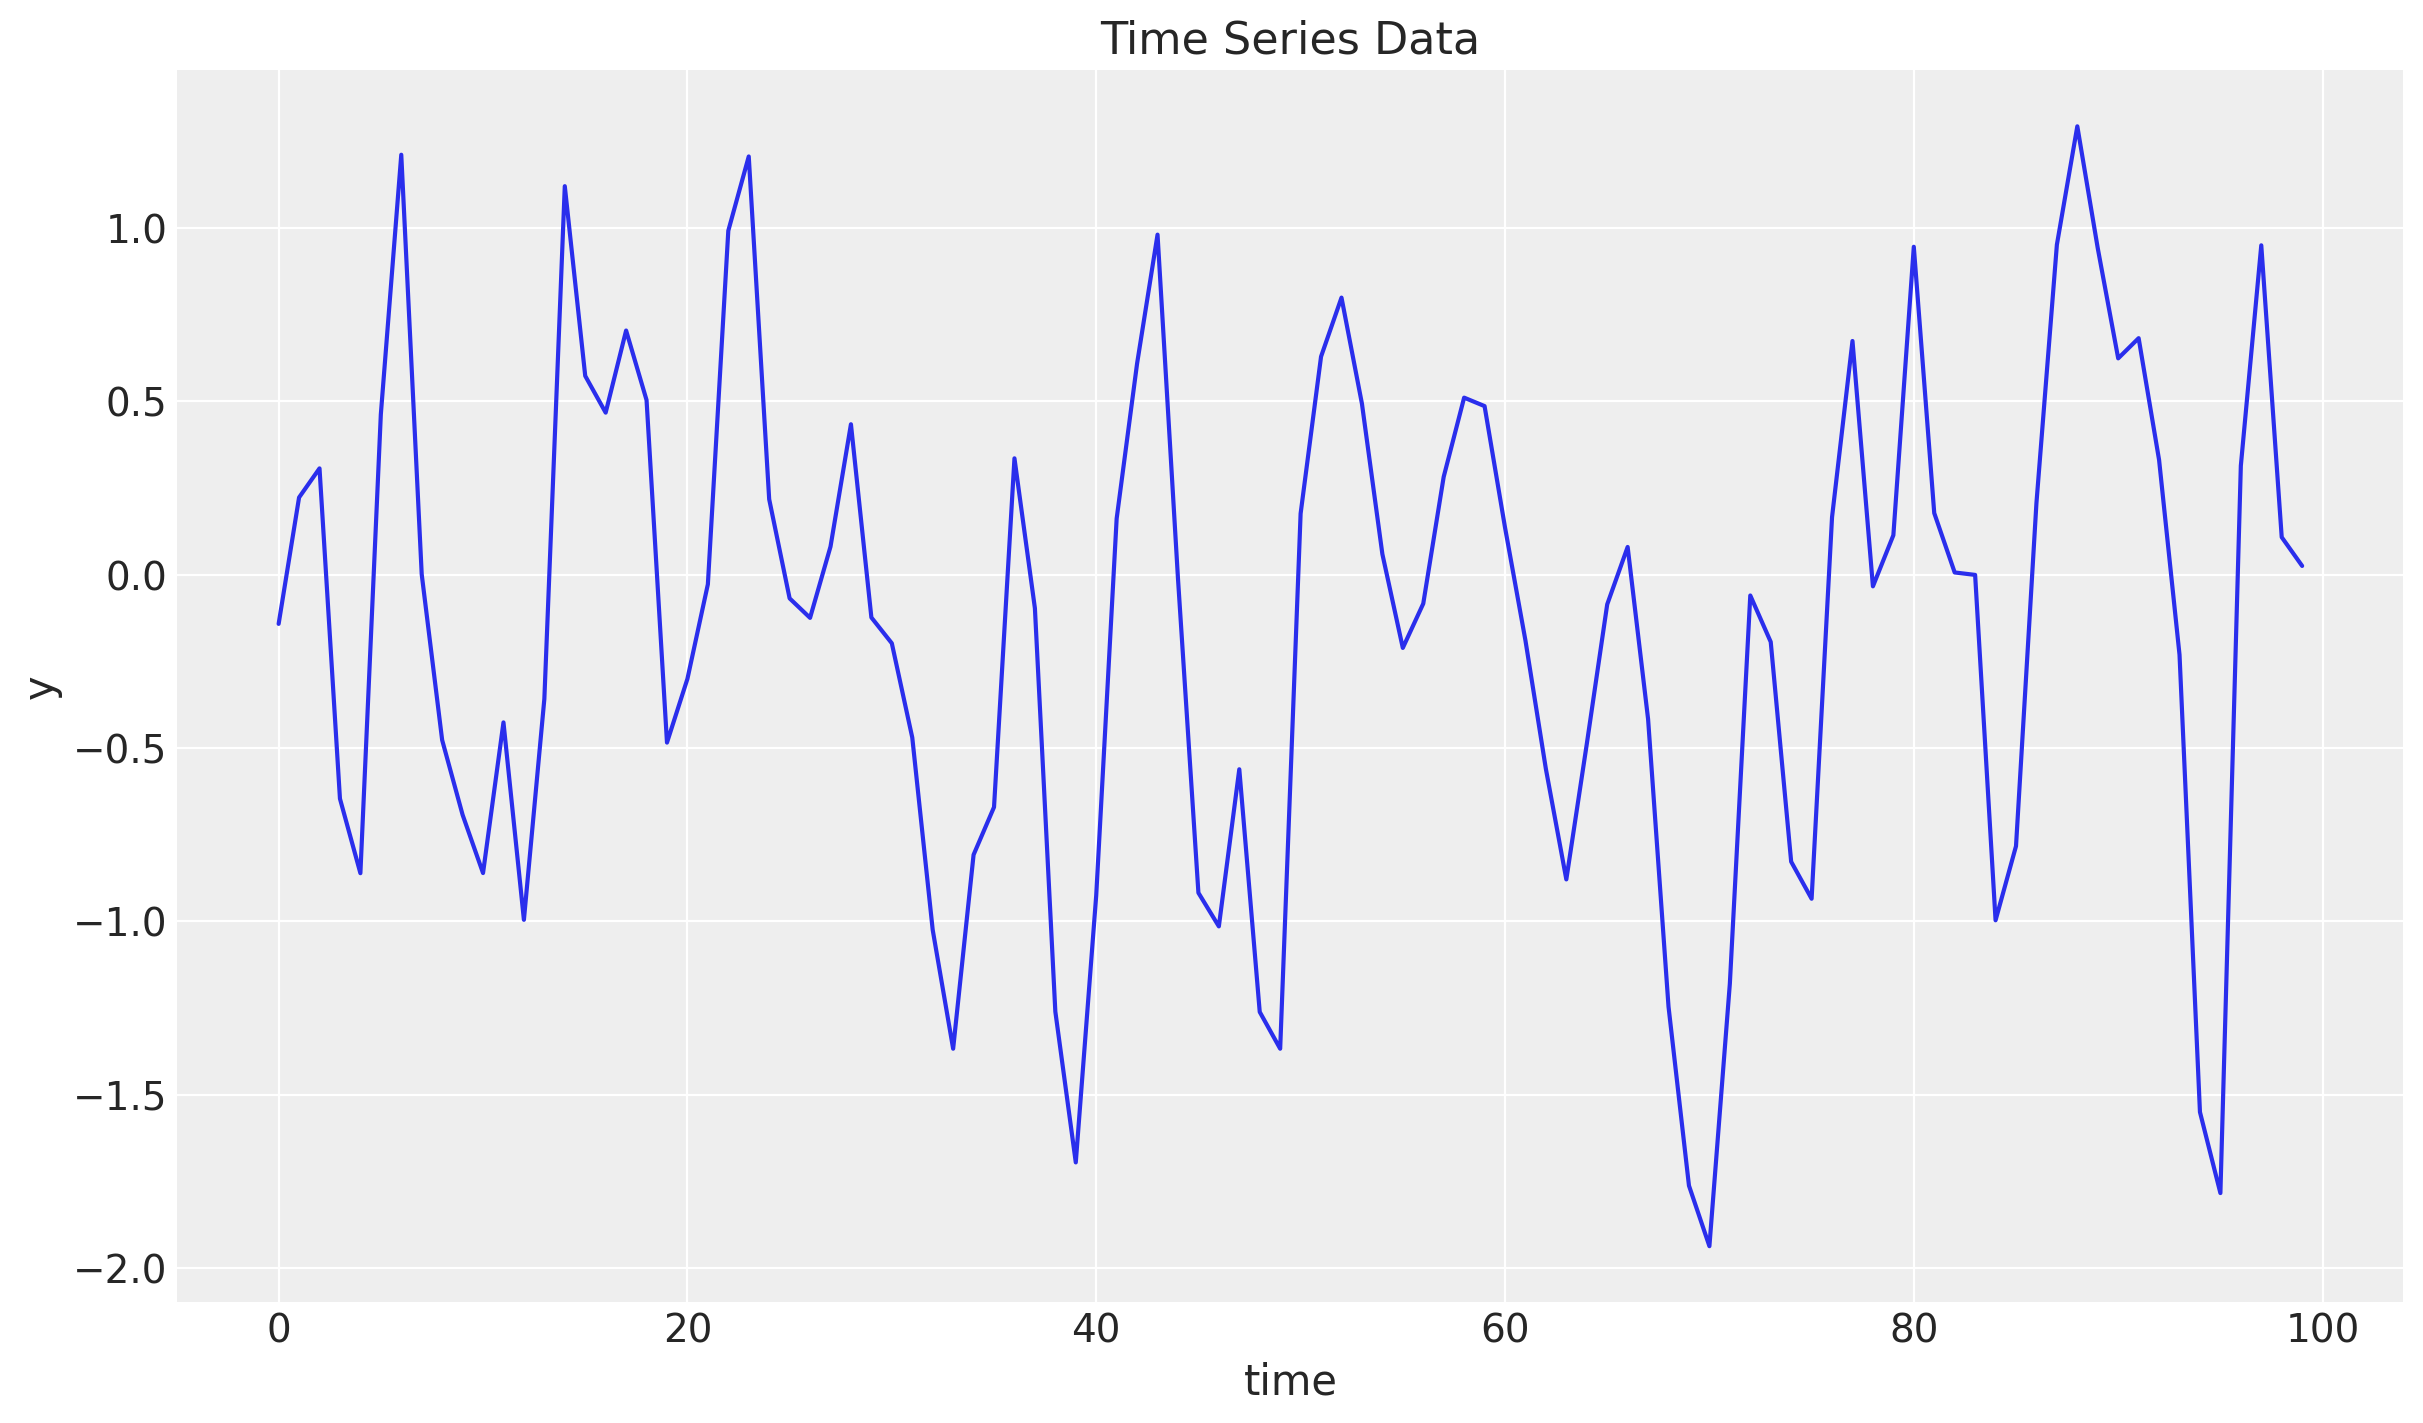

In [6]:
y = y_scan
t = jnp.arange(y.size)

fix, ax = plt.subplots()
ax.plot(t, y)
ax.set(xlabel="time", ylabel="y", title="Time Series Data")

We can plot the (partial) autocorrelation function to verify the time series has the expected structure.

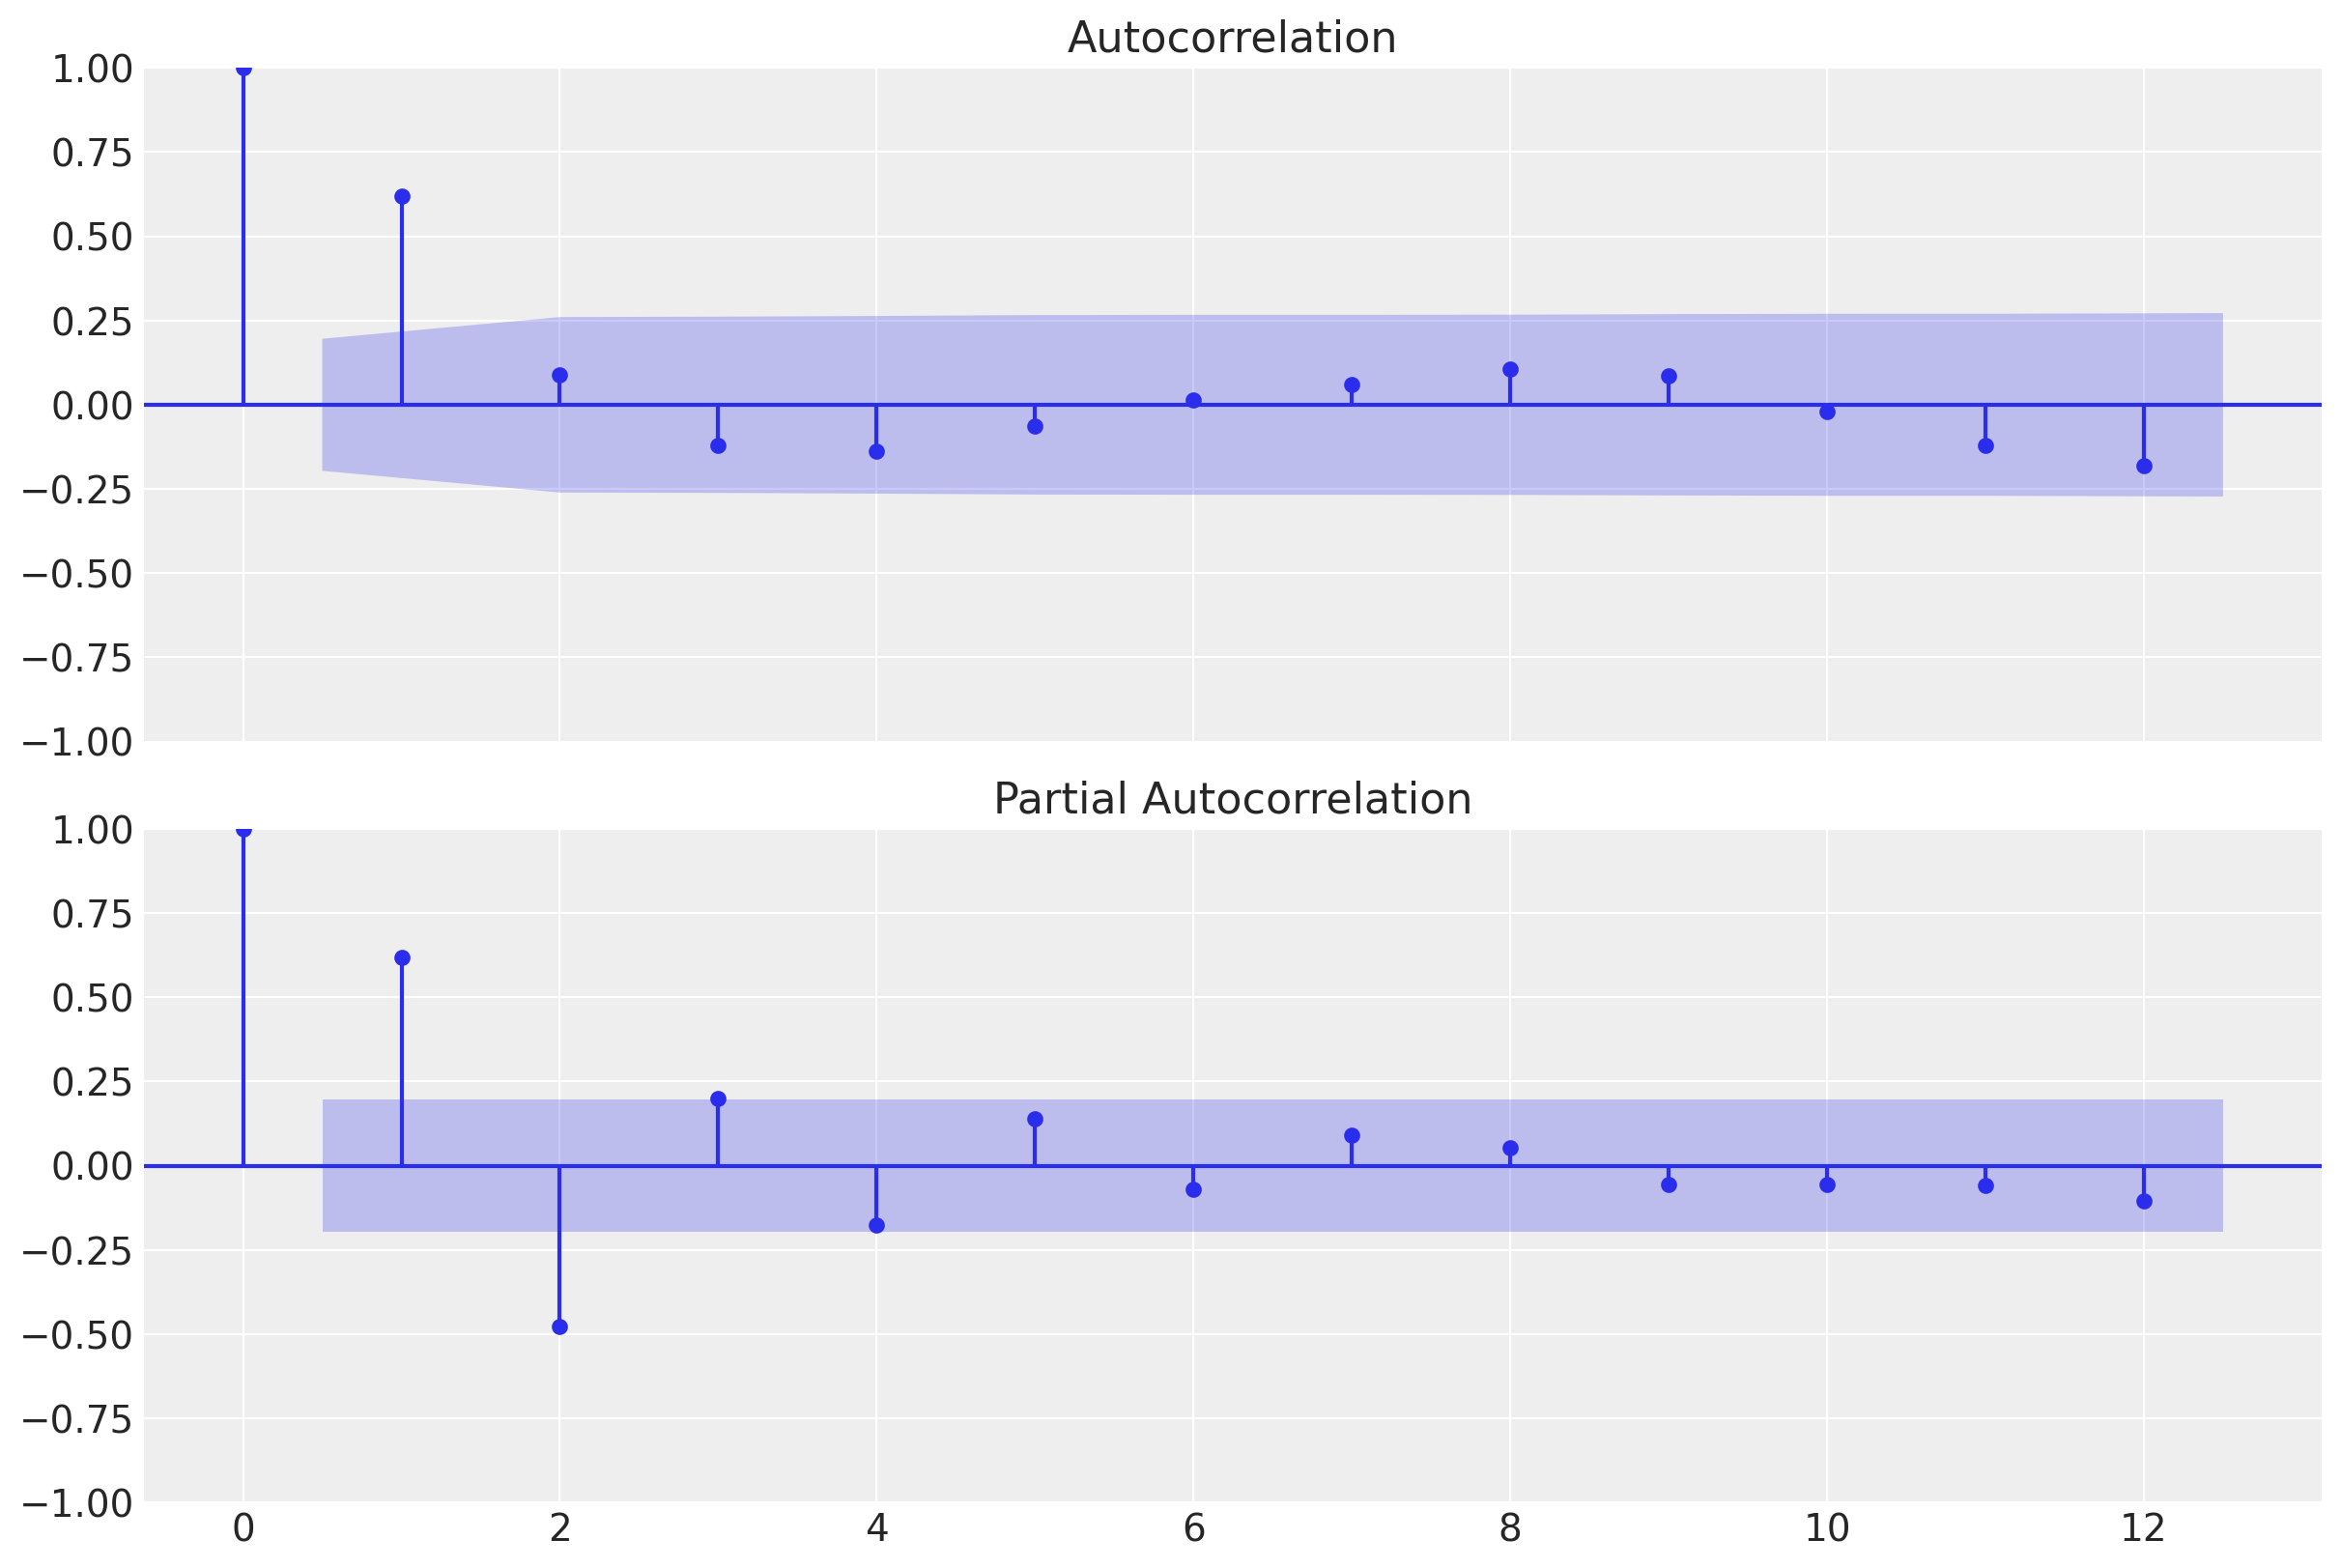

In [7]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 8), layout="constrained"
)

_ = plot_acf(y, lags=12, ax=ax[0])
_ = plot_pacf(y, lags=12, ax=ax[1])

### Train-Test Split

As usual, lets do a train-test split.

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

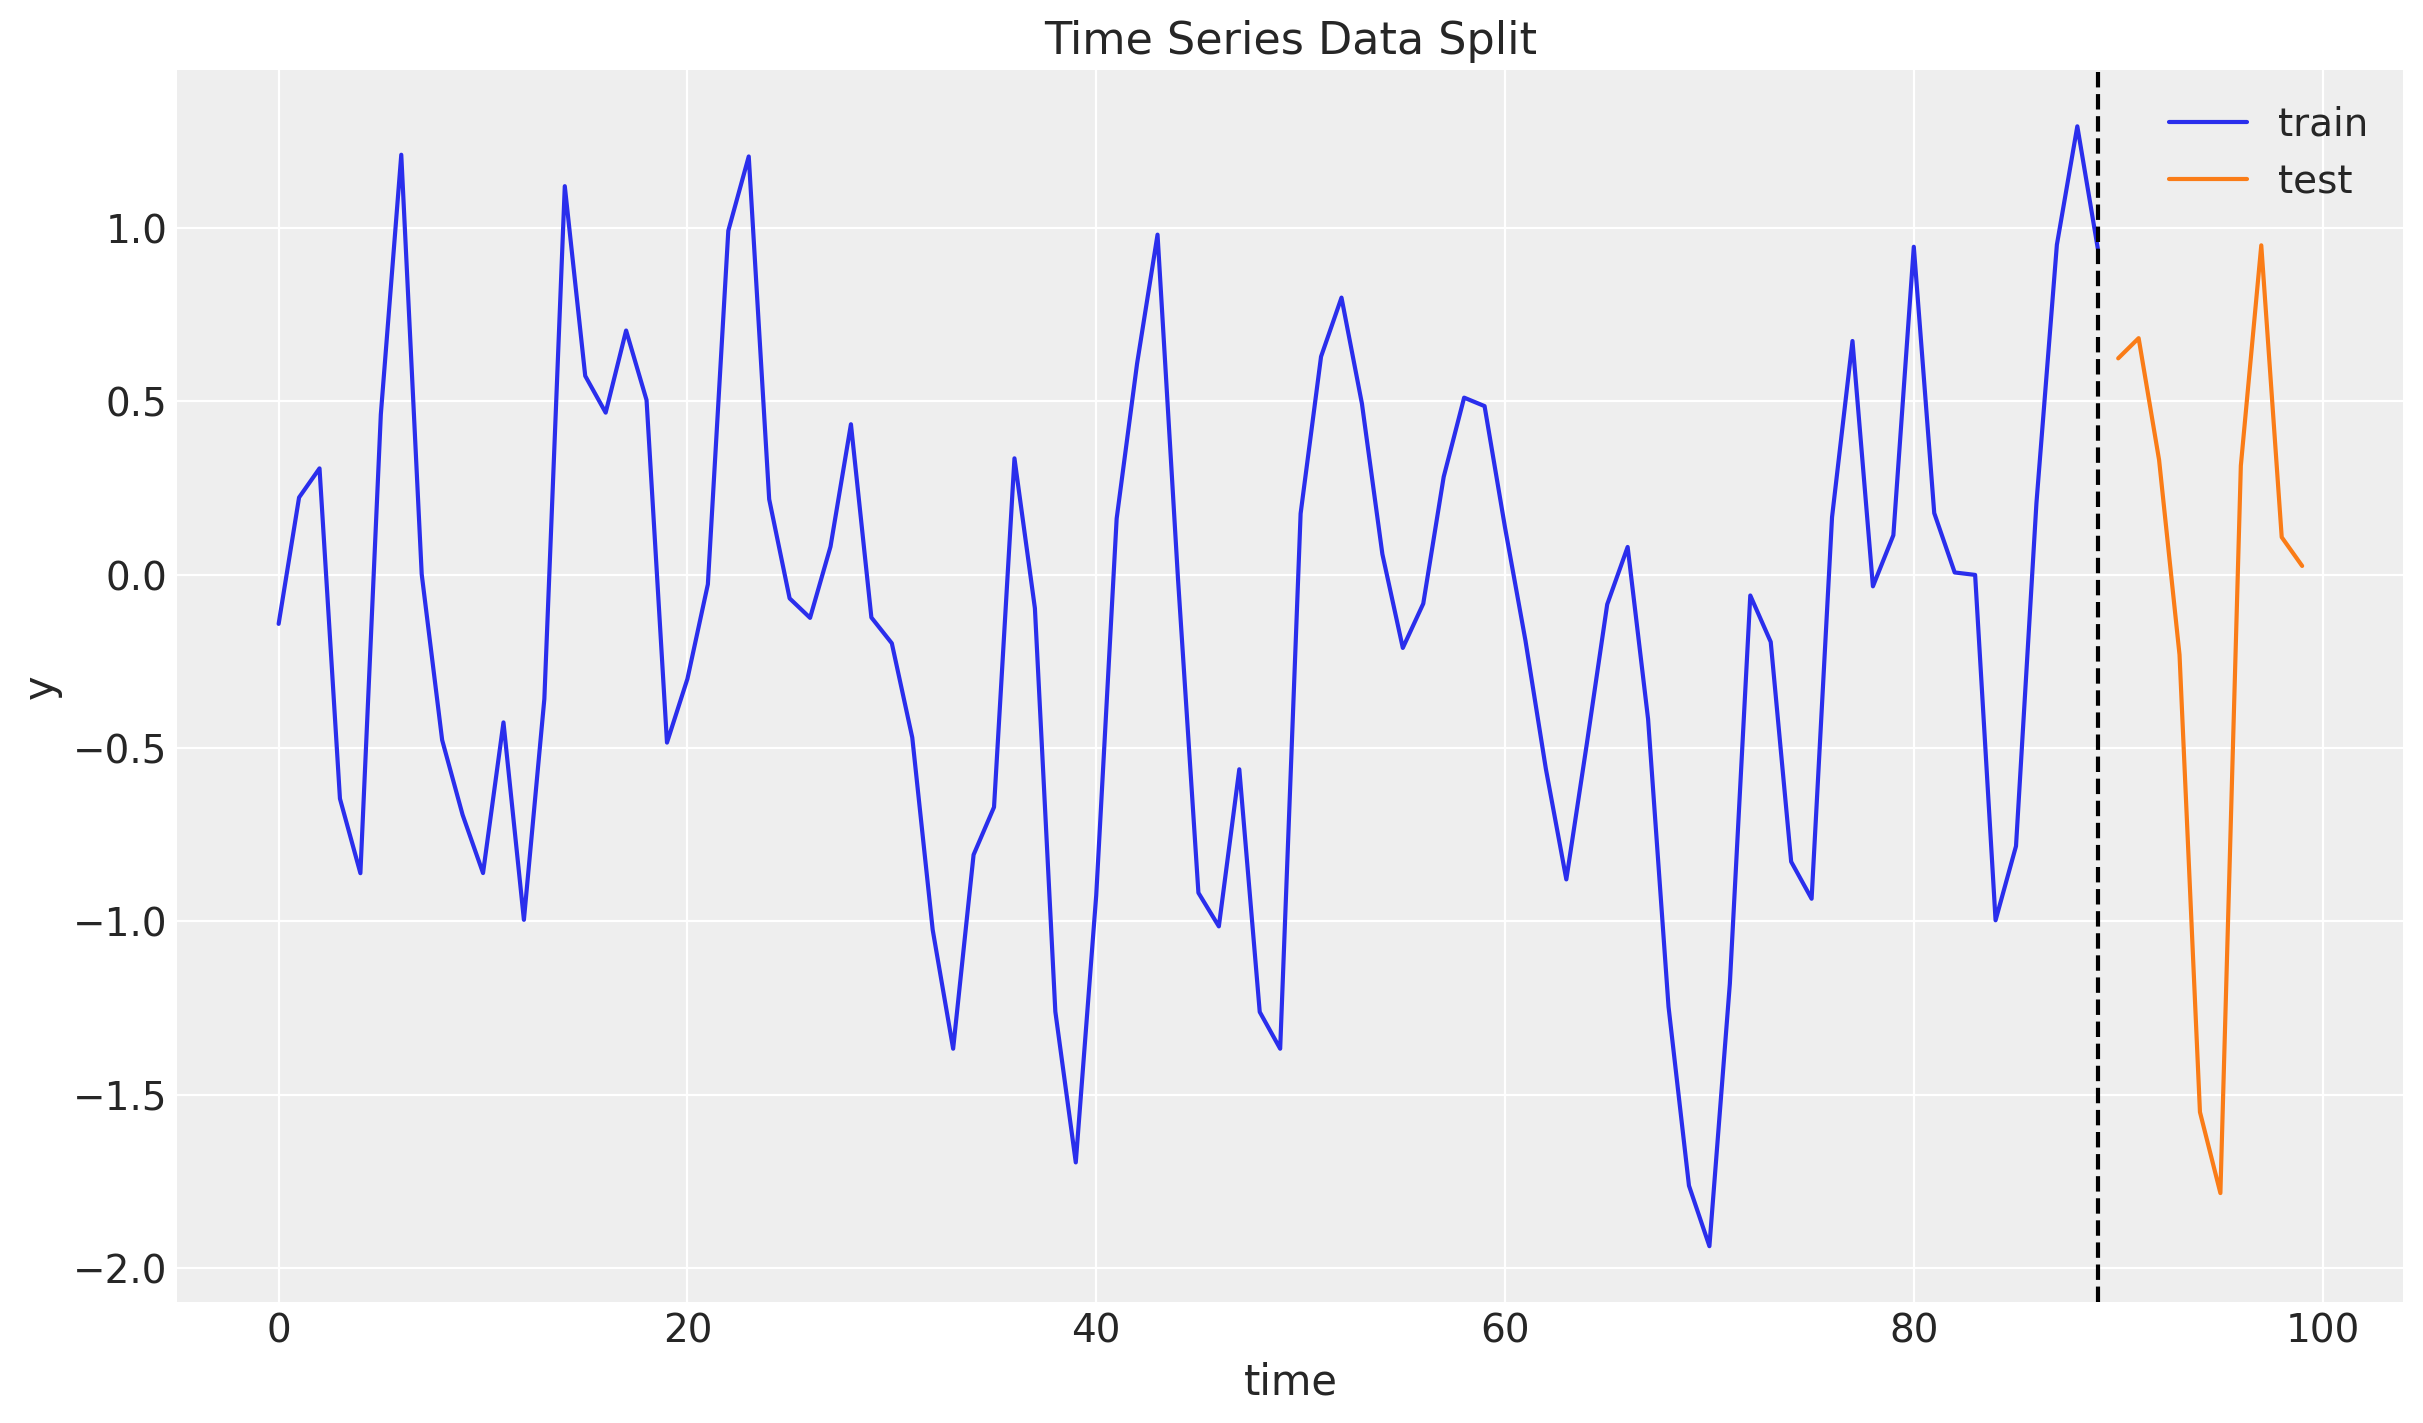

In [8]:
n = y.size

prop_train = 0.9
n_train = round(prop_train * n)

y_train = y[:n_train]
t_train = t[:n_train]

y_test = y[n_train:]
t_test = t[n_train:]

fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

## ARMA Model: Statsmodels

Before implementing the model in `NumPyro`, we can use the `statsmodels` library to fit the ARMA(1, 1) model. This is a good way to verify our implementation.

In [9]:
model = ARIMA(np.asarray(y_train), order=(1, 0, 1))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   90
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -62.856
Date:                Tue, 13 Feb 2024   AIC                            133.711
Time:                        10:39:35   BIC                            143.711
Sample:                             0   HQIC                           137.744
                                 - 90                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1404      0.134     -1.046      0.296      -0.403       0.123
ar.L1          0.3512      0.115      3.042      0.002       0.125       0.577
ma.L1          0.6938      0.083      8.407      0.000       0.532       0.856
sigma2         0.2335      0.043      5.466      0.000       0.150       0.317
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 1.50
Prob(Q):                              0.70   Prob(JB):                         0.47
Heteroskedasticity (H):               0.82   Skew:                             0.04
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We see that we get the same parameters as we used to generate the data.

We now use the fitted model to forecast on the test set.

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'ARMA(1, 1) Model Forecast (Statsmodels)')]

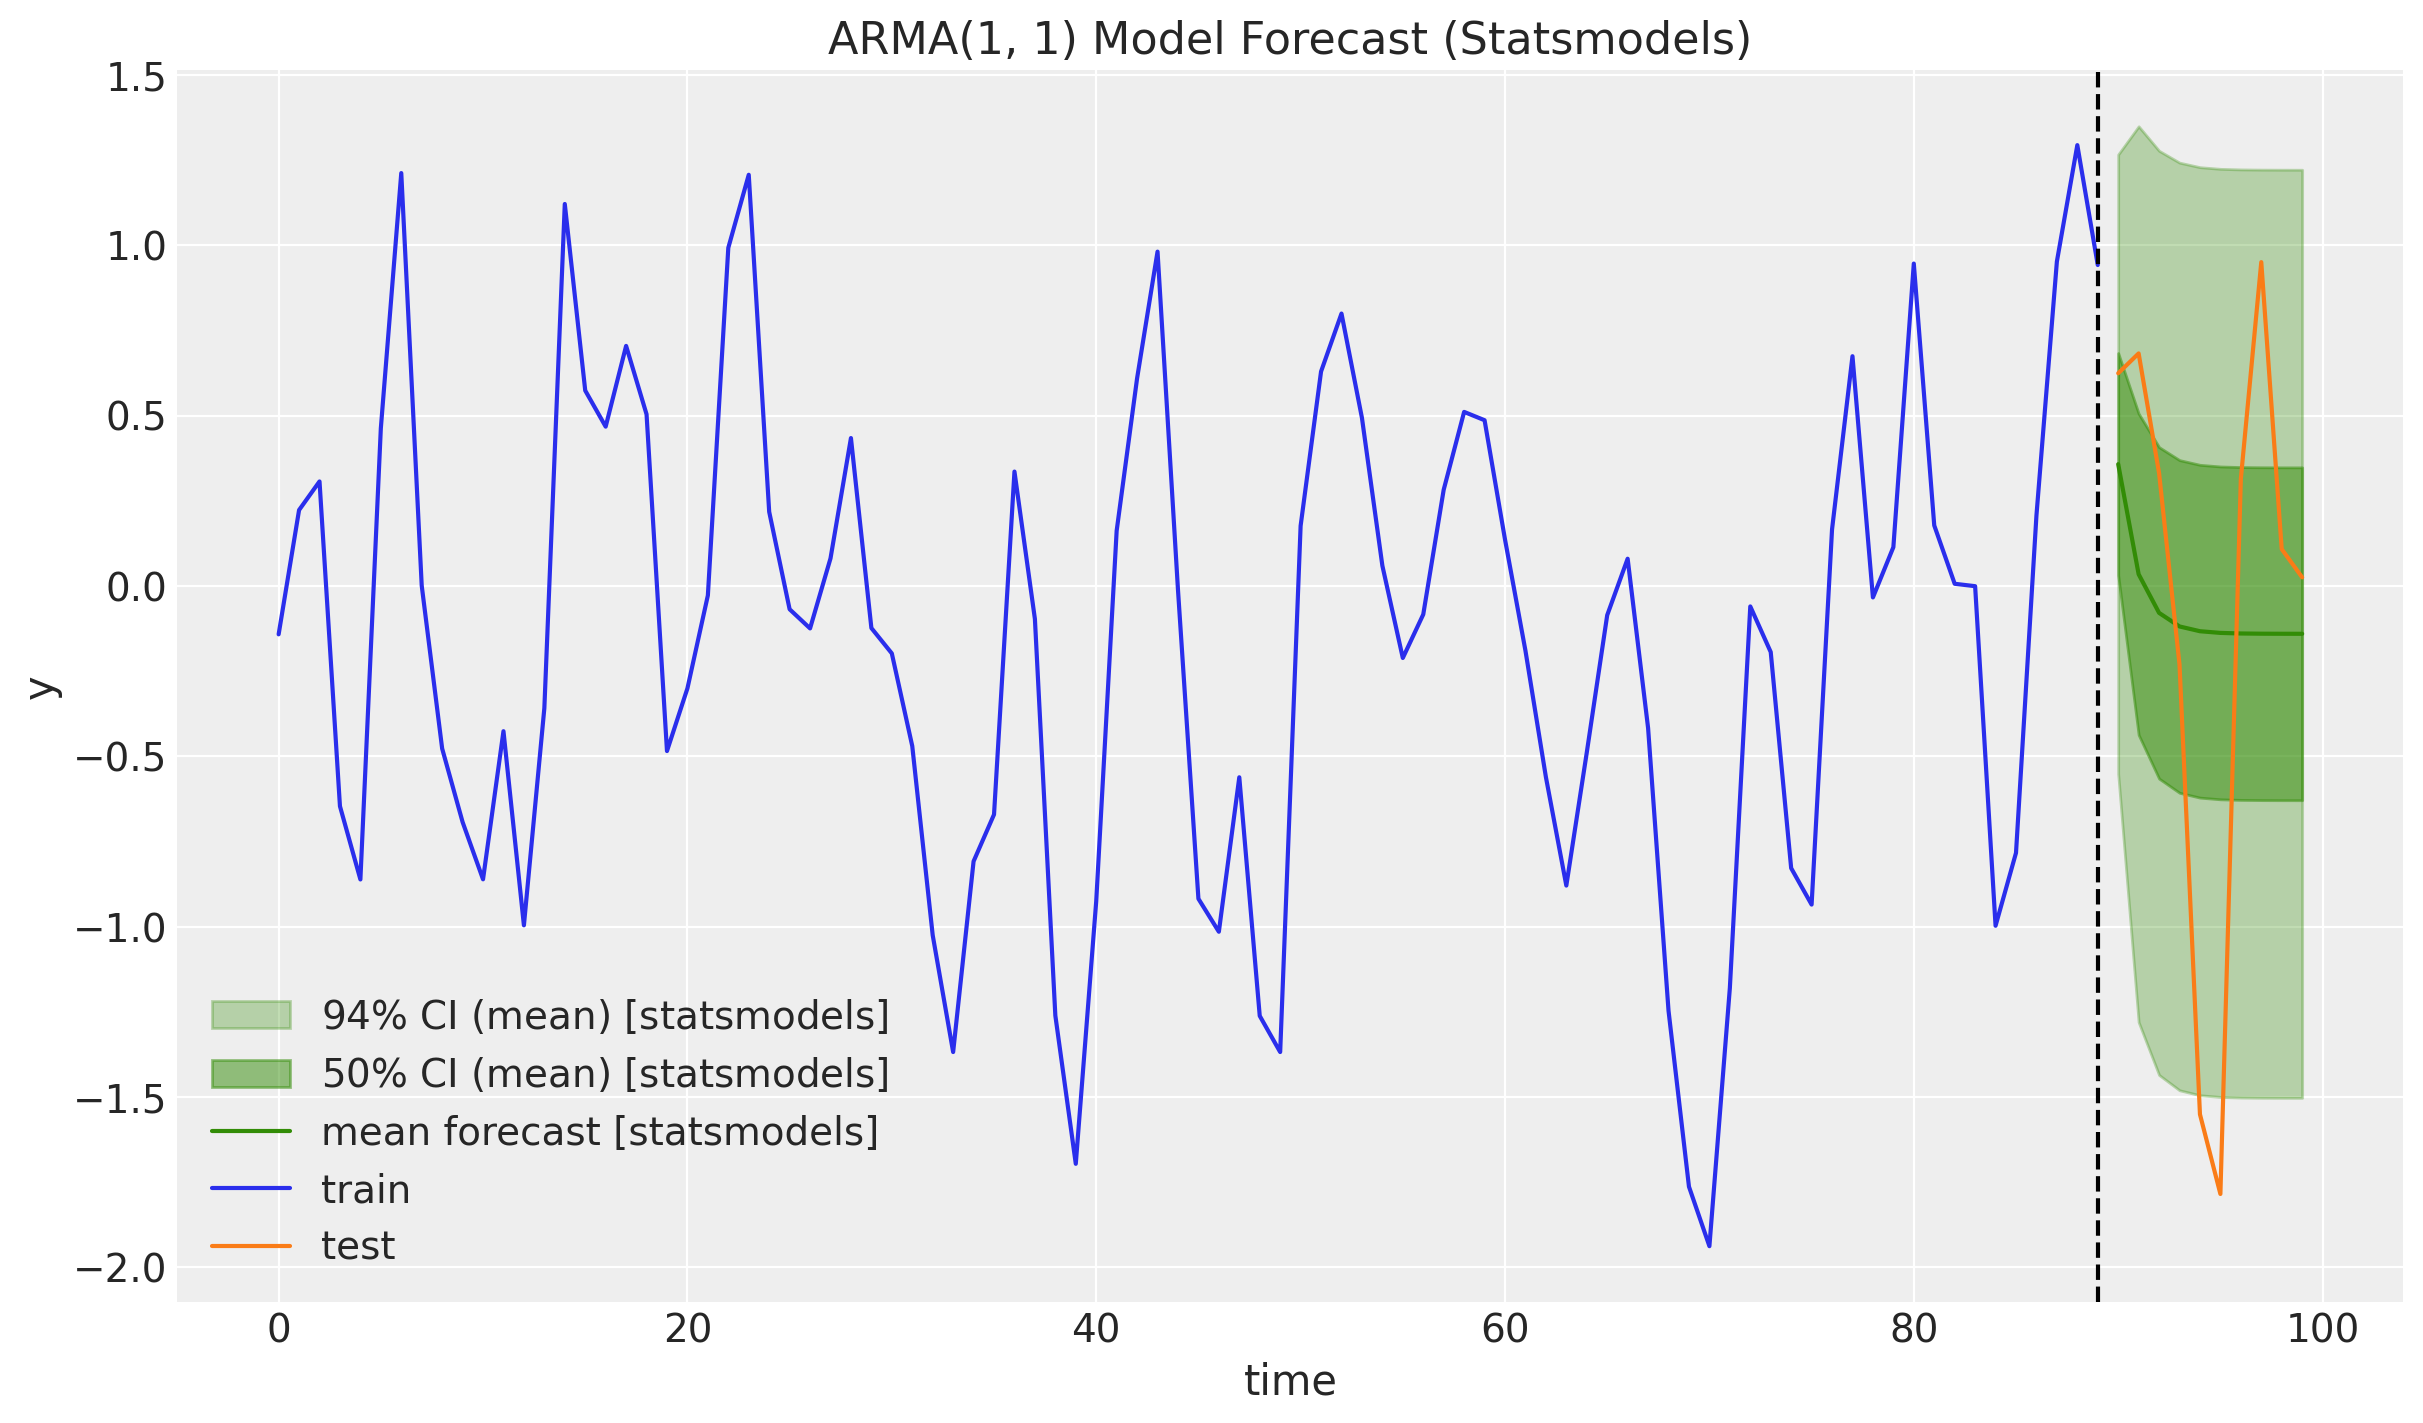

In [10]:
forecast_94_df = result.get_forecast(steps=y_test.size).summary_frame(alpha=0.06)
forecast_50_df = result.get_forecast(steps=y_test.size).summary_frame(alpha=0.5)

fig, ax = plt.subplots()
ax.fill_between(
    t_test,
    forecast_94_df["mean_ci_lower"],
    forecast_94_df["mean_ci_upper"],
    color="C2",
    alpha=0.3,
    label=r"$94\%$ CI (mean) [statsmodels]",
)
ax.fill_between(
    t_test,
    forecast_50_df["mean_ci_lower"],
    forecast_50_df["mean_ci_upper"],
    color="C2",
    alpha=0.5,
    label=r"$50\%$ CI (mean) [statsmodels]",
)
ax.plot(t_test, forecast_94_df["mean"], color="C2", label="mean forecast [statsmodels]")
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="ARMA(1, 1) Model Forecast (Statsmodels)")

## NumPyro ARMA(1, 1) Model

Now we are ready to implement the ARMA(1, 1) model in `NumPyro`.

### Model Specification

As mentioned in the introduction, we blend the strategies presented in the [Example: AR(2) process](https://num.pyro.ai/en/stable/examples/ar2.html) from the documentation and the discussion in the forum thread [Lax.scan to implement ARMA(1, 1)](https://forum.pyro.ai/t/lax-scan-to-implement-arma-1-1/3203). Overall, the strategy is similar as in the [exponential smoothing case](https://juanitorduz.github.io/time_based_regression_pymc/): set  priors, write the transition function and pass it trough `scan`. Still, there are two major differences (at least for my implementation):

- We do not condition on the data `y` but on the errors after passing them through scan. I learned this the hard was as the moving average parameter $\theta$ was unchanged from the prior when conditioning on `y`. This is simply because in the `scan` step the term `y[t] - pred` would vanish 🤦.

- Inside the model I had to write a custom prediction loop (via scan). The reason is that we want to recursively pass previous predictions for the autoregressive term. In addition, we need to set the errors to zero at prediction time (ecxept for the last one which we use the latest observed error). For a detailed discussion on the prediction step, please see the online chapter [Ch 9.8: ARIMA Models; Forecasting](https://otexts.com/fpp3/arima-forecasting.html#arima-forecasting).

In [11]:
def arma_1_1(y: ArrayImpl, future: int = 0) -> None:
    t_max = y.size
    mu = numpyro.sample("mu", dist.Normal(loc=0, scale=1))
    phi = numpyro.sample("phi", dist.Uniform(low=-1, high=1))
    theta = numpyro.sample("theta", dist.Uniform(low=-1, high=1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(scale=1))

    def transition_fn(carry, t):
        y_prev, error_prev = carry
        ar_part = phi * y_prev
        ma_part = theta * error_prev
        pred = mu + ar_part + ma_part
        error = y[t] - pred
        return (y[t], error), error

    error_0 = y[0] - (mu + phi * mu)
    _, errors = scan(transition_fn, (y[0], error_0), jnp.arange(1, t_max + future))

    errors = jnp.concat([error_0[None], errors])
    numpyro.sample("errors", dist.Normal(loc=0, scale=sigma), obs=errors)

    if future > 0:

        def prediction_fn(carry, _):
            y_prev, error_prev = carry
            ar_part = phi * y_prev
            ma_part = theta * error_prev
            pred = mu + ar_part + ma_part
            error = 0.0
            return (pred, error), pred

        _, y_forecast = scan(prediction_fn, (y[-1], errors[-1]), jnp.arange(future))
        numpyro.sample("y_forecast", dist.Normal(loc=y_forecast, scale=sigma))

### Inference

We are now ready to fit the model using `NumPyro`. We use the `NUTS` sampler.

In [12]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl,
    model: Callable,
    args: InferenceParams,
    *model_args,
    **nuts_kwargs,
) -> MCMC:
    sampler = NUTS(model, **nuts_kwargs)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc

In [13]:
inference_params = InferenceParams()
rng_key, rng_subkey = random.split(key=rng_key)
mcmc = run_inference(rng_subkey, arma_1_1, inference_params, y_train)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Let's look into the diagnostics and estimated parameters.

In [14]:
idata = az.from_numpyro(posterior=mcmc)

az.summary(data=idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.089,0.089,-0.266,0.071,0.001,0.001,6845.0,5324.0,1.0
phi,0.362,0.115,0.161,0.590,0.001,0.001,6520.0,5058.0,1.0
sigma,0.498,0.038,0.429,0.569,0.000,0.000,7348.0,5868.0,1.0
theta,0.678,0.083,0.527,0.831,0.001,0.001,6446.0,6010.0,1.0


In [15]:
print(f"""Divergences: {idata["sample_stats"]["diverging"].sum().item()}""")

Divergences: 0


Text(0.5, 0.98, 'Trace')

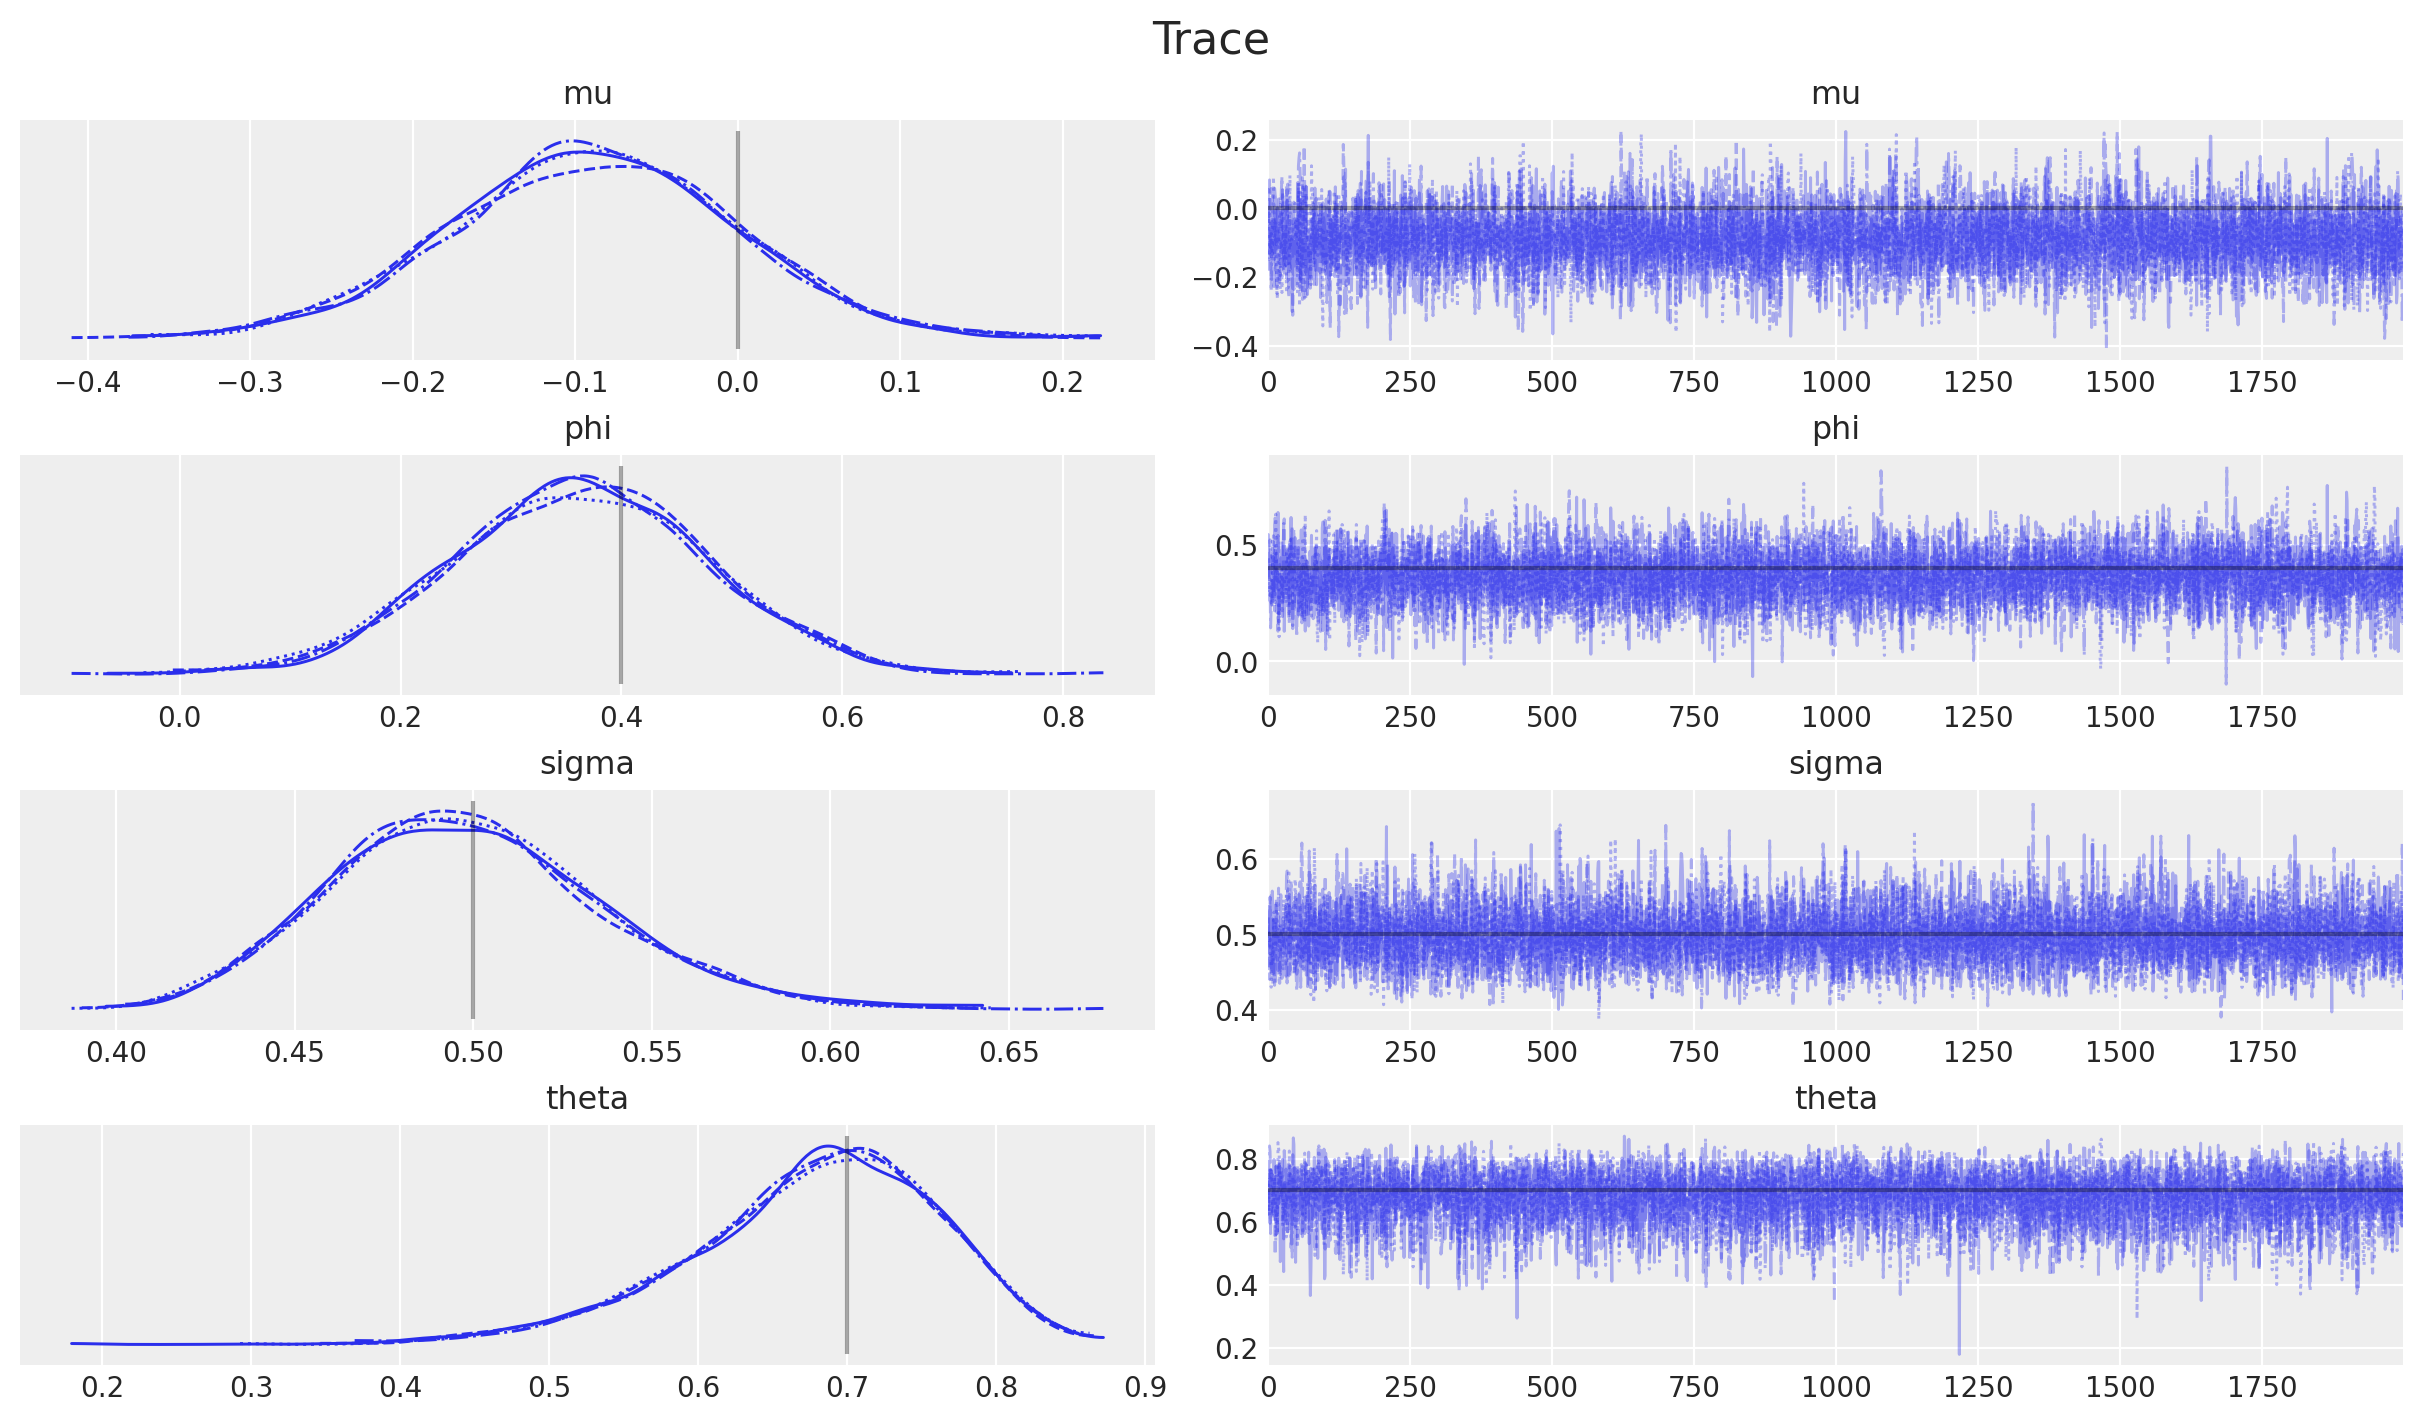

In [16]:
axes = az.plot_trace(
    data=idata,
    compact=True,
    lines=[
        ("mu", {}, mu),
        ("phi", {}, phi),
        ("theta", {}, theta),
        ("sigma", {}, noise_scale),
    ],
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Trace", fontsize=16)

the model diagnostics look fine. Also, note that wee have successfully recovered the parameters used to generate the data 🚀!

### Forecasting

We are now ready to forecast on the test set.

In [17]:
def forecast(
    rng_key: ArrayImpl, model: Callable, samples: dict[str, ArrayImpl], *model_args
) -> dict[str, ArrayImpl]:
    predictive = Predictive(
        model=model,
        posterior_samples=samples,
        return_sites=["y_forecast", "errors"],
    )
    return predictive(rng_key, *model_args)

In [18]:
rng_key, rng_subkey = random.split(key=rng_key)
forecast = forecast(rng_subkey, arma_1_1, mcmc.get_samples(), y_train, y_test.size)

In [19]:
posterior_predictive = az.from_numpyro(
    posterior_predictive=forecast,
    coords={"t_test": t_test, "t": t},
    dims={"y_forecast": ["t_test"], "errors": ["t"]},
)

We can now visualize the forecast at various credible intervals.

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'ARMA(1, 1) Model Forecast')]

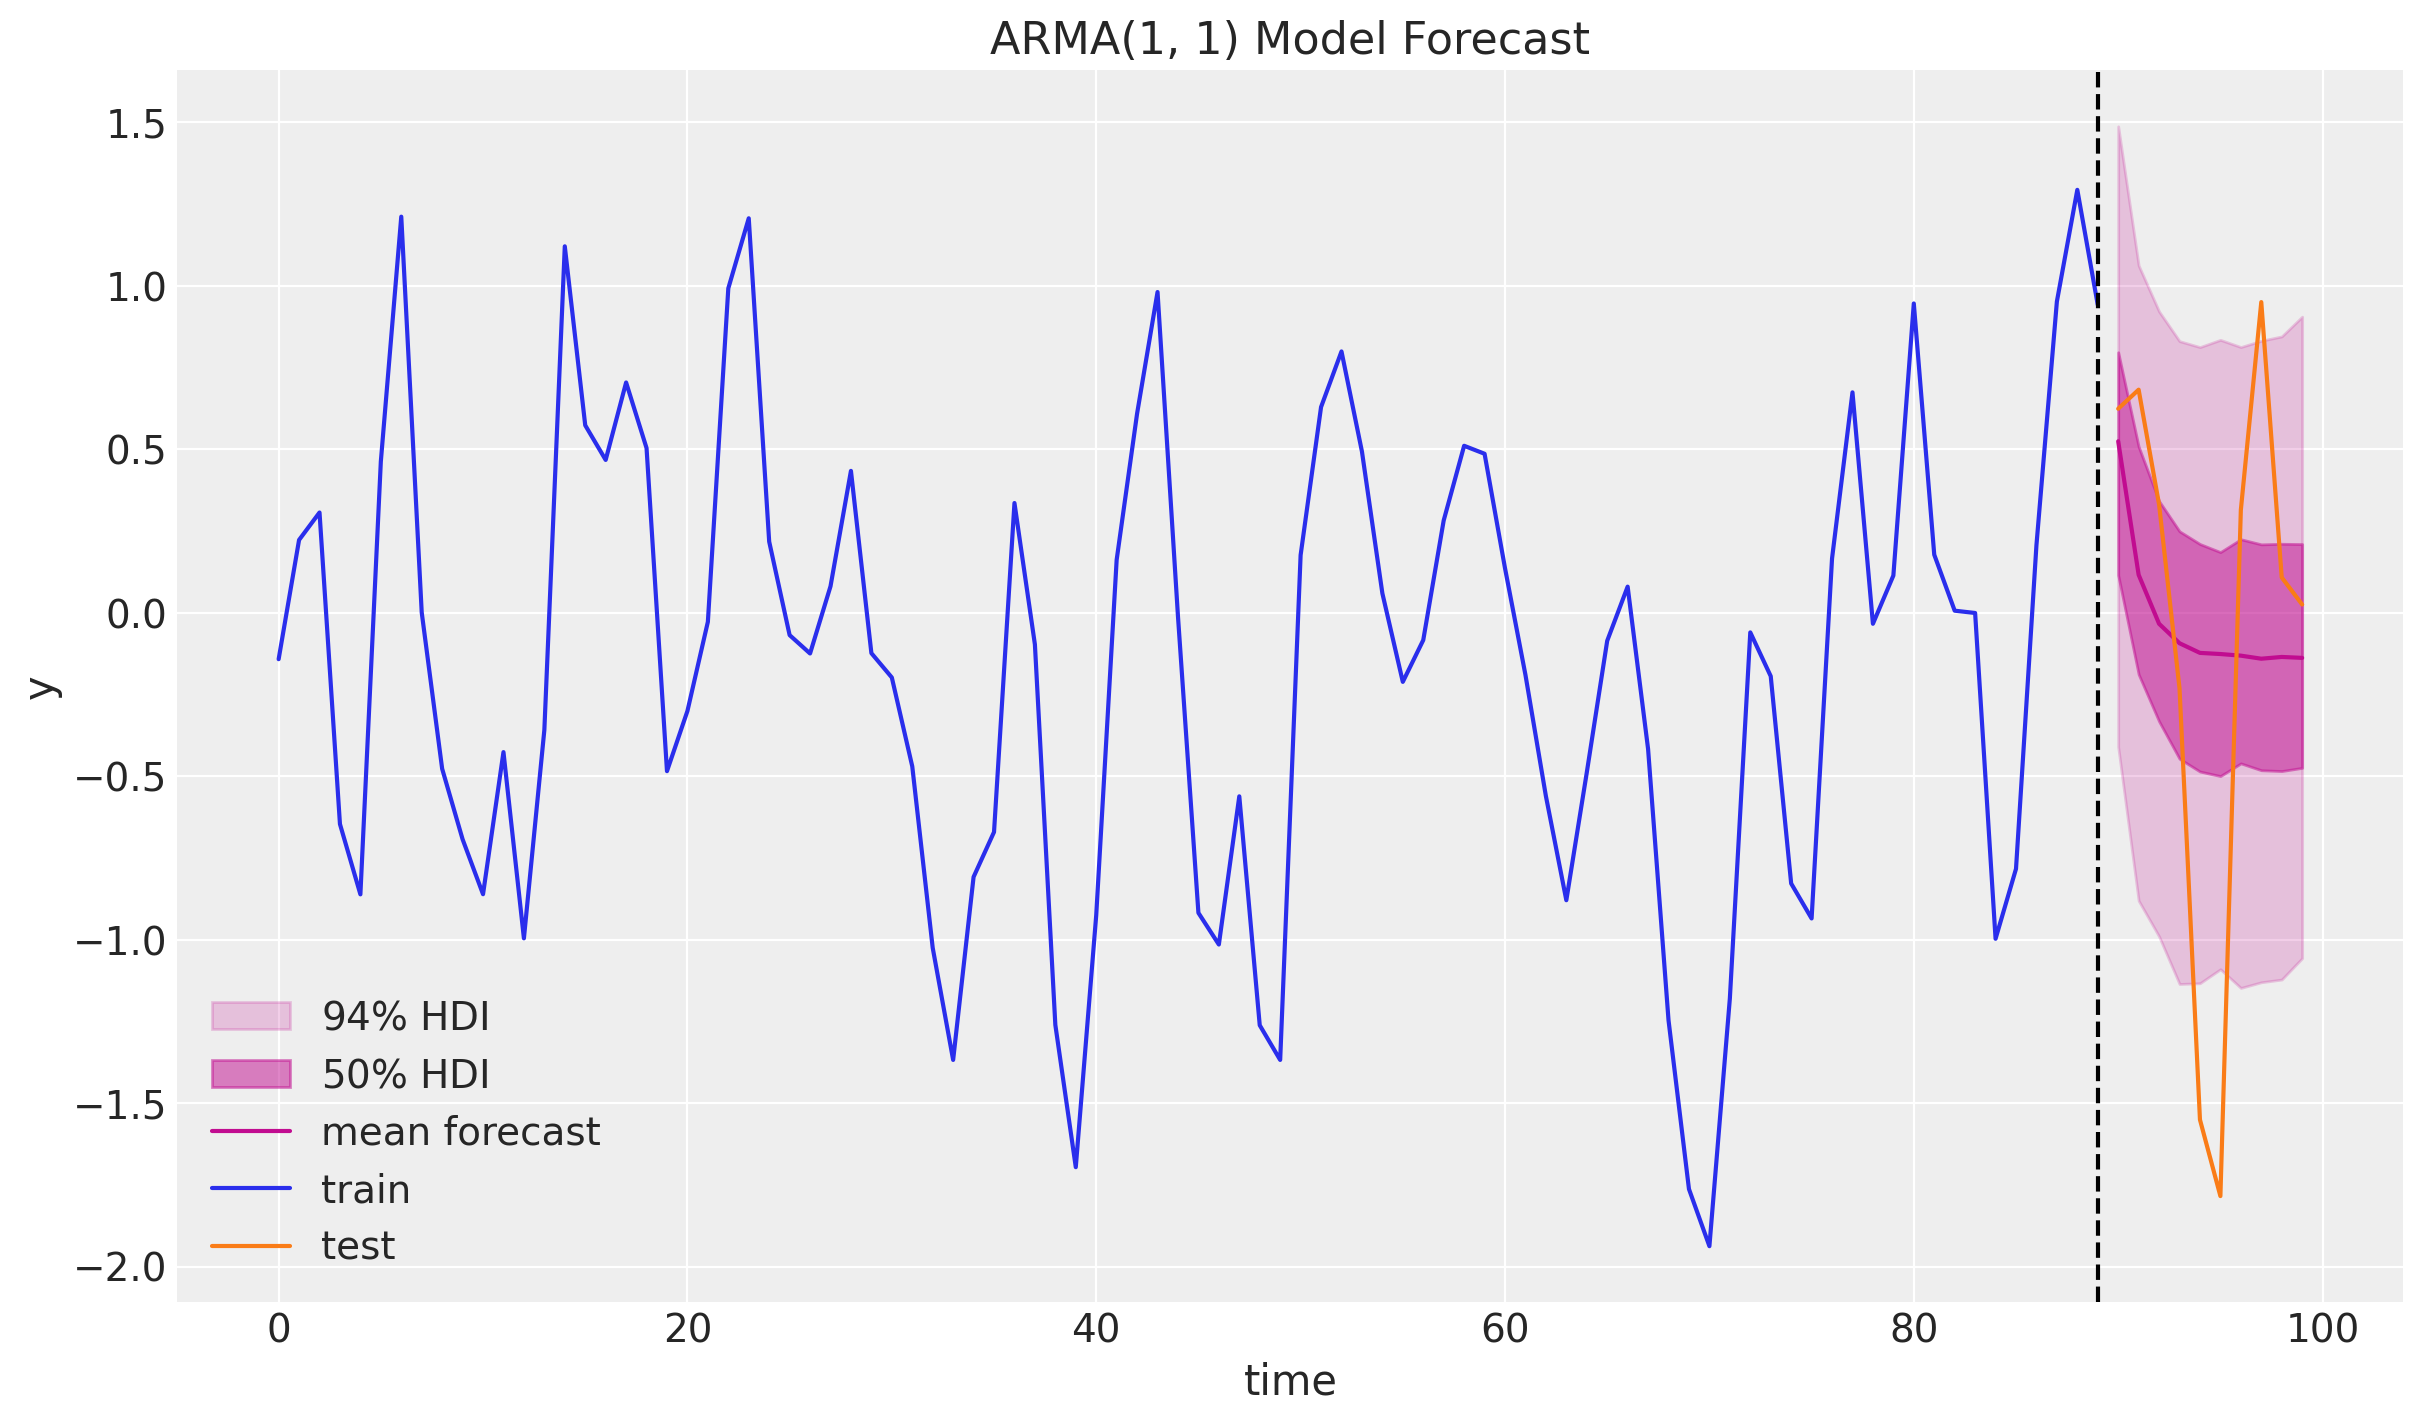

In [20]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.94,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.50,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    posterior_predictive["posterior_predictive"]["y_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C3",
    label="mean forecast",
)
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="ARMA(1, 1) Model Forecast")

The results look good and very comparable to the ones obtained using the `statsmodels` library:

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'ARMA(1, 1) Model Forecast - Model Comparison')]

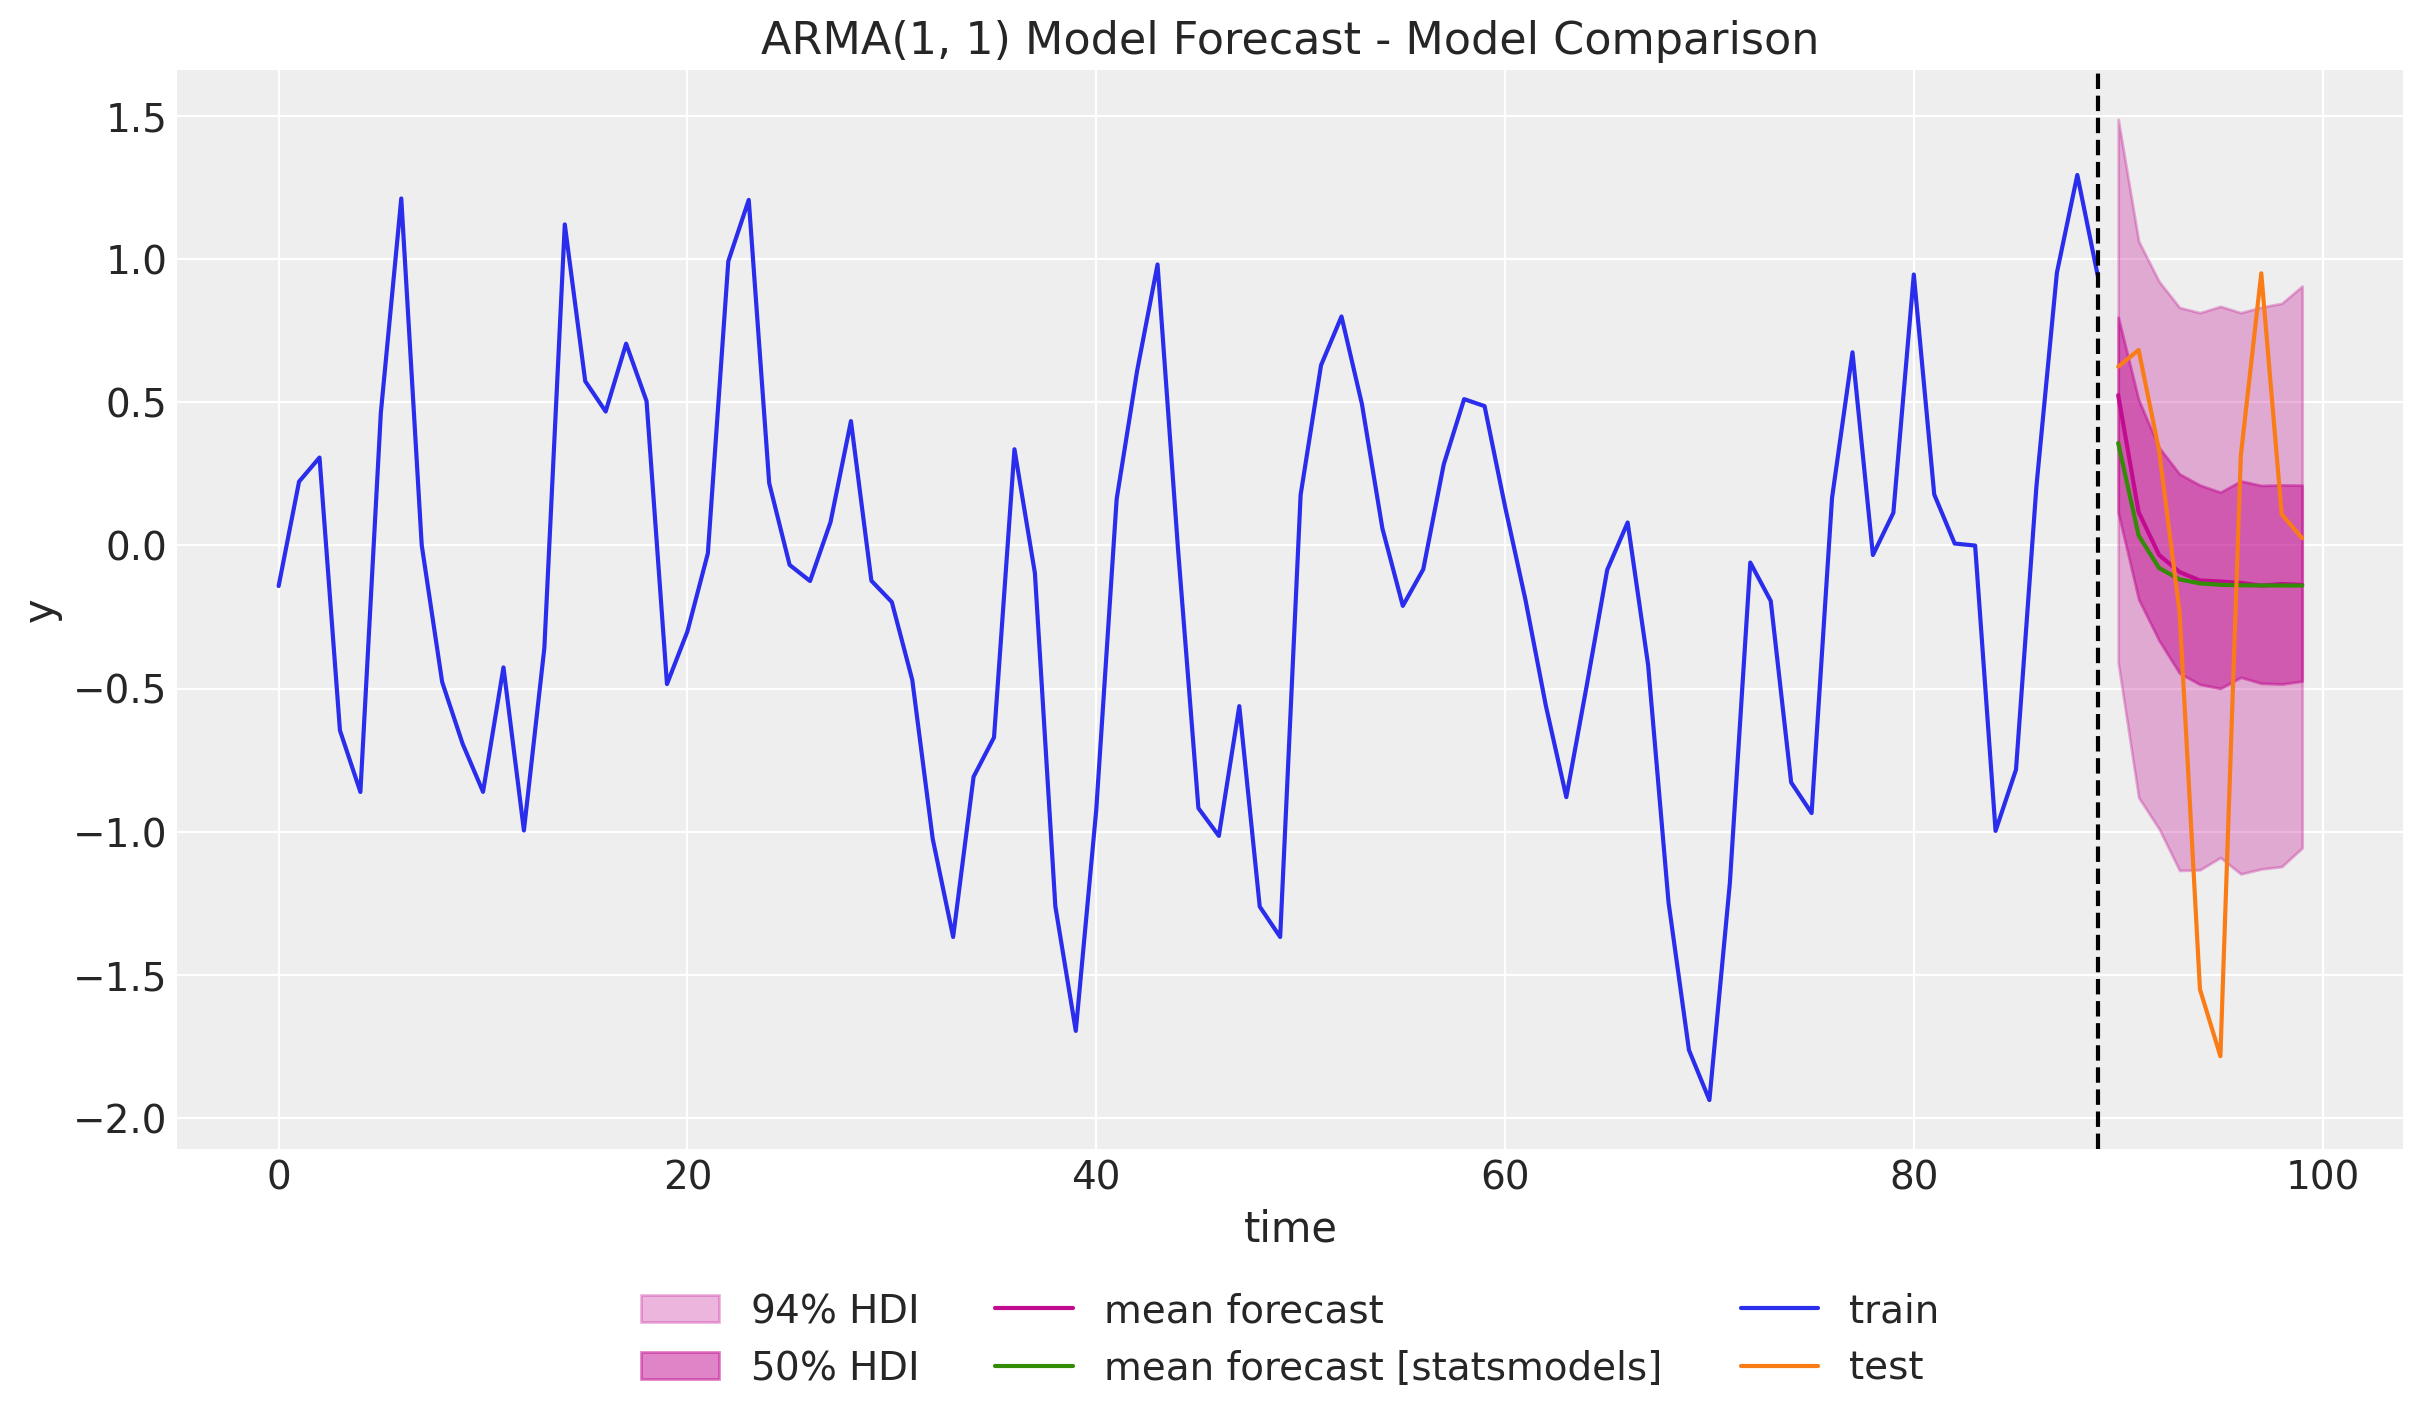

In [21]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.94,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.50,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    posterior_predictive["posterior_predictive"]["y_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C3",
    label="mean forecast",
)
ax.plot(t_test, forecast_94_df["mean"], color="C2", label="mean forecast [statsmodels]")
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="time", ylabel="y", title="ARMA(1, 1) Model Forecast - Model Comparison")

---
Using these learnings, it should not be hard to implement a general ARIMA(p, d, q) model. One has to be careful vectorizing the model to make it efficient.